In [76]:
import os
import glob
import numpy as np
import trimesh
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from skimage.measure import marching_cubes
from tqdm import tqdm
from monai.transforms import (
    Compose,
    RandRotated,         
    RandFlipd,           
    RandZoomd,           
    RandGaussianNoised,  
)
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [77]:
DATA_DIR_CAVITY = r""
DATA_DIR_FILLING = r""
CACHE_DIR = "./preprocessed_voxels_128_dimension/"

VOXEL_DIM = 128

BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 500
VISUALIZE_EVERY_N_EPOCHS = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
os.makedirs(CACHE_DIR, exist_ok=True)


Using device: cuda


In [78]:
def mesh_to_voxels(stl_path, dimension=64, pad=2):
    try:
        mesh = trimesh.load(stl_path)
        if not mesh.is_watertight:
            mesh.fill_holes()
        mesh.apply_translation(-mesh.centroid)
        max_extent = np.max(mesh.extents)
        pitch = max_extent / (dimension - 2 * pad)
        voxels = mesh.voxelized(pitch=pitch)
        filled_voxels = voxels.fill().matrix.astype(np.float32)
        x, y, z = filled_voxels.shape
        grid = np.zeros((dimension, dimension, dimension), dtype=np.float32)
        x_start = (dimension - x) // 2
        y_start = (dimension - y) // 2
        z_start = (dimension - z) // 2
        grid[x_start:x_start+x, y_start:y_start+y, z_start:z_start+z] = filled_voxels
        return grid
    except Exception as e:
        print(f"Error processing {stl_path}: {e}")
        return np.zeros((dimension, dimension, dimension), dtype=np.float32)

def visualize_progress(epoch, sample_input, sample_gt, prediction):
    input_slice = sample_input.detach().cpu().numpy().squeeze()
    gt_slice = sample_gt.detach().cpu().numpy().squeeze()
    pred_slice = (torch.sigmoid(prediction).detach().cpu().numpy().squeeze() > 0.5).astype(np.float32)
    slice_idx = VOXEL_DIM // 2
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(input_slice[slice_idx, :, :], cmap='bone'); axes[0].set_title("Input Cavity"); axes[0].axis('off')
    axes[1].imshow(gt_slice[slice_idx, :, :], cmap='Greens'); axes[1].set_title("Ground Truth Filling"); axes[1].axis('off')
    axes[2].imshow(pred_slice[slice_idx, :, :], cmap='Oranges'); axes[2].set_title(f"Predicted Filling (Epoch {epoch})"); axes[2].axis('off')
    plt.show()



In [79]:
cavity_files = sorted(glob.glob(os.path.join(DATA_DIR_CAVITY, "*.stl")))
filling_files = sorted(glob.glob(os.path.join(DATA_DIR_FILLING, "*.stl")))

if not cavity_files or not filling_files or len(cavity_files) != len(filling_files):
    raise FileNotFoundError("Could not find matching STL files. Check your paths and ensure file counts are equal.")
print(f"Found {len(cavity_files)} cavity files and {len(filling_files)} filling files.")

print("Preprocessing and caching data...")
for i in tqdm(range(len(cavity_files))):
    cavity_path = cavity_files[i]
    filling_path = filling_files[i]
    base_name = os.path.basename(cavity_path).replace('.stl', '')
    cavity_cache_path = os.path.join(CACHE_DIR, f"{base_name}_cavity.npy")
    filling_cache_path = os.path.join(CACHE_DIR, f"{base_name.replace('_cavity_', '_filling_')}_filling.npy") # Robust naming
    
    if not os.path.exists(cavity_cache_path) or not os.path.exists(filling_cache_path):
        cavity_voxels = mesh_to_voxels(cavity_path, dimension=VOXEL_DIM)
        filling_voxels = mesh_to_voxels(filling_path, dimension=VOXEL_DIM)
        np.save(cavity_cache_path, cavity_voxels)
        np.save(filling_cache_path, filling_voxels)
print("Preprocessing complete.")


Found 1050 cavity files and 1050 filling files.
Preprocessing and caching data...


100%|███████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<00:00, 79816.21it/s]

Preprocessing complete.


In [80]:
train_transforms = Compose([
    RandRotated(keys=["image", "label"], range_x=0.1, range_y=0.1, range_z=0.1, prob=0.4, keep_size=True),
    RandFlipd(keys=["image", "label"], spatial_axis=[0, 1, 2], prob=0.4),
    RandZoomd(keys=["image", "label"], min_zoom=0.95, max_zoom=1.05, prob=0.4),
    RandGaussianNoised(keys=["image"], prob=0.1, std=0.01),
])

In [81]:
class ToothDataset(Dataset):
    def __init__(self, cavity_files, filling_files, transform=None):
        self.cavity_files = cavity_files
        self.filling_files = filling_files
        self.transform = transform

    def __len__(self):
        return len(self.cavity_files)

    def __getitem__(self, idx):
        cavity_voxels = np.load(self.cavity_files[idx])
        filling_voxels = np.load(self.filling_files[idx])
        sample = {
            "image": torch.from_numpy(cavity_voxels).unsqueeze(0),
            "label": torch.from_numpy(filling_voxels).unsqueeze(0)
        }
        if self.transform:
            sample = self.transform(sample)
        return sample

In [82]:
all_cavity_files = sorted(glob.glob(os.path.join(CACHE_DIR, "*_cavity.npy")))
all_filling_files = sorted(glob.glob(os.path.join(CACHE_DIR, "*_filling.npy")))
indices = list(range(len(all_cavity_files)))
np.random.shuffle(indices)
split_point = int(0.8 * len(indices))
train_indices, val_indices = indices[:split_point], indices[split_point:]

In [83]:
#train_transforms = None #During first stage of the trainig, the model is trained without data augmentation.

train_dataset = ToothDataset(
    cavity_files=[all_cavity_files[i] for i in train_indices],
    filling_files=[all_filling_files[i] for i in train_indices],
    transform=train_transforms
)
val_dataset = ToothDataset(
    cavity_files=[all_cavity_files[i] for i in val_indices],
    filling_files=[all_filling_files[i] for i in val_indices],
    transform=None
)

In [84]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

print(f"Dataset ready: {len(train_dataset)} training, {len(val_dataset)} validation samples.")

Dataset ready: 840 training, 210 validation samples.


In [85]:
import torch.nn as nn
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    dropout=0.2
).to(device)

loss_function = DiceLoss(to_onehot_y=False, sigmoid=True)
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True)
bce_loss = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.Adam(model.parameters(), LEARNING_RATE) #during first stage of the training
optimizer = torch.optim.Adam(model.parameters(), LEARNING_RATE / 10) #during retraining learning rate is reduced
MIN_LR = 1e-6 
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5,min_lr=MIN_LR)

def combined_loss(pred, target):
    return dice_loss(pred, target) + bce_loss(pred, target)

print("Model, Loss, and Optimizer are ready.")

Model, Loss, and Optimizer are ready.


✅ Successfully loaded weights from Stage 1 for fine-tuning.
🚀 Starting training...
--------------------
Epoch 1/500


Training: 100%|████████████████████████████████████████████████████████████████████████| 53/53 [04:30<00:00,  5.11s/it]


Epoch 1 average training loss: 0.7929


Validating: 100%|████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.66it/s]


Epoch 1 validation metric (Dice): 0.8571
✅ New best model saved with metric: 0.8571
--------------------
Epoch 2/500


Training: 100%|████████████████████████████████████████████████████████████████████████| 53/53 [04:43<00:00,  5.34s/it]


Epoch 2 average training loss: 0.6149


Validating: 100%|████████████████████████████████████████████████████████████████████| 210/210 [00:44<00:00,  4.71it/s]


Epoch 2 validation metric (Dice): 0.8447
--------------------
Epoch 3/500


Training: 100%|████████████████████████████████████████████████████████████████████████| 53/53 [04:40<00:00,  5.29s/it]


Epoch 3 average training loss: 0.5730


Validating: 100%|████████████████████████████████████████████████████████████████████| 210/210 [00:44<00:00,  4.71it/s]


Epoch 3 validation metric (Dice): 0.8393
--------------------
Epoch 4/500


Training: 100%|████████████████████████████████████████████████████████████████████████| 53/53 [04:40<00:00,  5.30s/it]


Epoch 4 average training loss: 0.5605


Validating: 100%|████████████████████████████████████████████████████████████████████| 210/210 [00:44<00:00,  4.71it/s]


Epoch 4 validation metric (Dice): 0.8344
--------------------
Epoch 5/500


Training: 100%|████████████████████████████████████████████████████████████████████████| 53/53 [04:41<00:00,  5.30s/it]


Epoch 5 average training loss: 0.5604


Validating: 100%|████████████████████████████████████████████████████████████████████| 210/210 [00:44<00:00,  4.72it/s]


Epoch 5 validation metric (Dice): 0.8319
--------------------
Epoch 6/500


Training: 100%|████████████████████████████████████████████████████████████████████████| 53/53 [04:36<00:00,  5.22s/it]


Epoch 6 average training loss: 0.5343


Validating: 100%|████████████████████████████████████████████████████████████████████| 210/210 [00:44<00:00,  4.70it/s]


Epoch 6 validation metric (Dice): 0.8335
--------------------
Epoch 7/500


Training: 100%|████████████████████████████████████████████████████████████████████████| 53/53 [04:36<00:00,  5.22s/it]


Epoch 7 average training loss: 0.5368


Validating: 100%|████████████████████████████████████████████████████████████████████| 210/210 [00:44<00:00,  4.75it/s]


Epoch 7 validation metric (Dice): 0.8332
--------------------
Epoch 8/500


Training: 100%|████████████████████████████████████████████████████████████████████████| 53/53 [04:35<00:00,  5.20s/it]


Epoch 8 average training loss: 0.5323


Validating: 100%|████████████████████████████████████████████████████████████████████| 210/210 [00:44<00:00,  4.74it/s]


Epoch 8 validation metric (Dice): 0.8329
--------------------
Epoch 9/500


Training: 100%|████████████████████████████████████████████████████████████████████████| 53/53 [04:36<00:00,  5.21s/it]


Epoch 9 average training loss: 0.5218


Validating: 100%|████████████████████████████████████████████████████████████████████| 210/210 [00:44<00:00,  4.73it/s]


Epoch 9 validation metric (Dice): 0.8336
--------------------
Epoch 10/500


Training: 100%|████████████████████████████████████████████████████████████████████████| 53/53 [04:38<00:00,  5.25s/it]


Epoch 10 average training loss: 0.5326


Validating: 100%|████████████████████████████████████████████████████████████████████| 210/210 [00:44<00:00,  4.73it/s]


Epoch 10 validation metric (Dice): 0.8328
--------------------
Epoch 11/500


Training: 100%|████████████████████████████████████████████████████████████████████████| 53/53 [04:38<00:00,  5.26s/it]


Epoch 11 average training loss: 0.5086


Validating: 100%|████████████████████████████████████████████████████████████████████| 210/210 [00:44<00:00,  4.70it/s]


Epoch 11 validation metric (Dice): 0.8348
--------------------
Epoch 12/500


Training: 100%|████████████████████████████████████████████████████████████████████████| 53/53 [04:38<00:00,  5.25s/it]


Epoch 12 average training loss: 0.5308


Validating: 100%|████████████████████████████████████████████████████████████████████| 210/210 [00:44<00:00,  4.74it/s]


Epoch 12 validation metric (Dice): 0.8347
--------------------
Epoch 13/500


Training: 100%|████████████████████████████████████████████████████████████████████████| 53/53 [04:37<00:00,  5.23s/it]


Epoch 13 average training loss: 0.5232


Validating: 100%|████████████████████████████████████████████████████████████████████| 210/210 [00:44<00:00,  4.67it/s]


Epoch 13 validation metric (Dice): 0.8355
--------------------
Epoch 14/500


Training: 100%|████████████████████████████████████████████████████████████████████████| 53/53 [04:39<00:00,  5.27s/it]


Epoch 14 average training loss: 0.5241


Validating: 100%|████████████████████████████████████████████████████████████████████| 210/210 [00:44<00:00,  4.69it/s]


Epoch 14 validation metric (Dice): 0.8349
--------------------
Epoch 15/500


Training: 100%|████████████████████████████████████████████████████████████████████████| 53/53 [04:36<00:00,  5.22s/it]


Epoch 15 average training loss: 0.5220


Validating: 100%|████████████████████████████████████████████████████████████████████| 210/210 [00:44<00:00,  4.71it/s]


Epoch 15 validation metric (Dice): 0.8352
--------------------
Epoch 16/500


Training: 100%|████████████████████████████████████████████████████████████████████████| 53/53 [04:39<00:00,  5.28s/it]


Epoch 16 average training loss: 0.5222


Validating: 100%|████████████████████████████████████████████████████████████████████| 210/210 [00:44<00:00,  4.69it/s]


Epoch 16 validation metric (Dice): 0.8350
--------------------
Epoch 17/500


Training: 100%|████████████████████████████████████████████████████████████████████████| 53/53 [04:40<00:00,  5.29s/it]


Epoch 17 average training loss: 0.5347


Validating: 100%|████████████████████████████████████████████████████████████████████| 210/210 [00:44<00:00,  4.71it/s]


Epoch 17 validation metric (Dice): 0.8352
--------------------
Epoch 18/500


Training: 100%|████████████████████████████████████████████████████████████████████████| 53/53 [04:58<00:00,  5.63s/it]


Epoch 18 average training loss: 0.5161


Validating: 100%|████████████████████████████████████████████████████████████████████| 210/210 [00:52<00:00,  4.01it/s]


Epoch 18 validation metric (Dice): 0.8353
--------------------
Epoch 19/500


Training: 100%|████████████████████████████████████████████████████████████████████████| 53/53 [04:50<00:00,  5.49s/it]


Epoch 19 average training loss: 0.5206


Validating: 100%|████████████████████████████████████████████████████████████████████| 210/210 [00:44<00:00,  4.71it/s]


Epoch 19 validation metric (Dice): 0.8358
--------------------
Epoch 20/500


Training: 100%|████████████████████████████████████████████████████████████████████████| 53/53 [04:36<00:00,  5.21s/it]


Epoch 20 average training loss: 0.5262


Validating: 100%|████████████████████████████████████████████████████████████████████| 210/210 [00:44<00:00,  4.73it/s]


Epoch 20 validation metric (Dice): 0.8356

--- Visualizing progress at epoch 20 ---


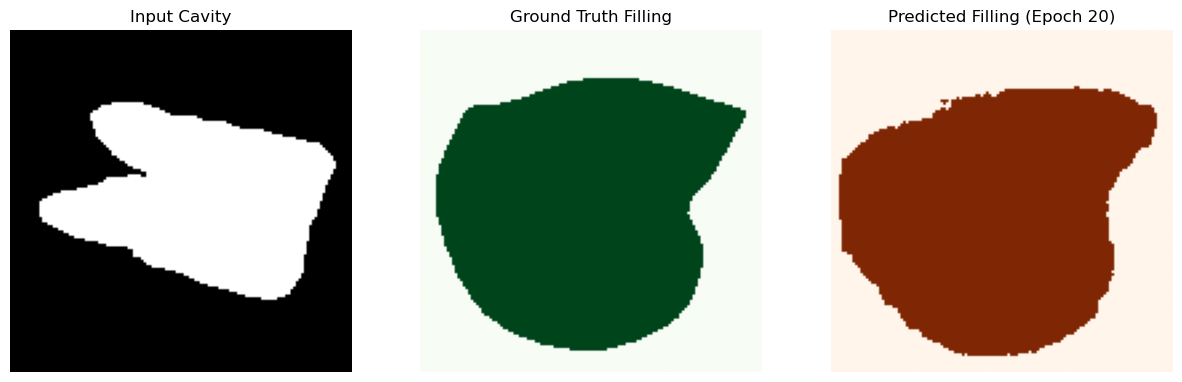

--------------------
Epoch 21/500


Training: 100%|████████████████████████████████████████████████████████████████████████| 53/53 [04:35<00:00,  5.20s/it]


Epoch 21 average training loss: 0.5143


Validating: 100%|████████████████████████████████████████████████████████████████████| 210/210 [00:44<00:00,  4.70it/s]

Epoch 21 validation metric (Dice): 0.8360
Validation metric has not improved for 20 epochs. Stopping training.

🎉 Training complete!
Best validation metric was 0.8571 at epoch 1.


In [86]:
best_metric = -1
best_metric_epoch = -1
patience = 20
epochs_no_improve = 0
vis_sample = next(iter(val_loader)) # Get a sample for visualization
vis_input, vis_gt = vis_sample["image"].to(device), vis_sample["label"].to(device)

#during retraining, model is loaded
# model.load_state_dict(torch.load("best_metric_model.pth"))
# print("Successfully loaded weights from Stage 1 for fine-tuning.")

print("Starting training...")
for epoch in range(NUM_EPOCHS):
    print("-" * 20)
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    model.train()
    epoch_loss = 0
    
    for batch_data in tqdm(train_loader, desc="Training"):
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = combined_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch + 1} average training loss: {epoch_loss / len(train_loader):.4f}")

    # Validation phase
    model.eval()
    metric_sum = 0.0
    with torch.no_grad():
        for val_data in tqdm(val_loader, desc="Validating"):
            val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)
            val_outputs = sliding_window_inference(val_inputs, (VOXEL_DIM, VOXEL_DIM, VOXEL_DIM), 4, model)
            metric_sum += 1.0 - loss_function(val_outputs, val_labels).item()
            
    current_metric = metric_sum / len(val_loader)
    print(f"Epoch {epoch + 1} validation metric (Dice): {current_metric:.4f}")
    
    if current_metric > best_metric:
        best_metric = current_metric
        best_metric_epoch = epoch + 1
        torch.save(model.state_dict(), "best_metric_model.pth")
        print(f"✅ New best model saved with metric: {best_metric:.4f}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    # Step the scheduler based on the validation metric
    scheduler.step(current_metric)

    current_lr = optimizer.param_groups[0]['lr']

    if epochs_no_improve == patience:
        print(f"Validation metric has not improved for {patience} epochs. Stopping training.")
        break

    if current_lr <= MIN_LR:
        print(f"\nLearning rate has reached the minimum threshold ({MIN_LR}). Stopping training.")
        break
            
    # Visualization check
    if (epoch + 1) % VISUALIZE_EVERY_N_EPOCHS == 0:
        print(f"\n--- Visualizing progress at epoch {epoch + 1} ---")
        model.eval()
        with torch.no_grad():
            vis_pred = model(vis_input)
            visualize_progress(epoch + 1, vis_input, vis_gt, vis_pred) 

print("\n🎉 Training complete!")
print(f"Best validation metric was {best_metric:.4f} at epoch {best_metric_epoch}.")